# UiBench benchmark on Android

This benchmark is used to evaluate the responsiveness of an Android system to user interaction. Also **systraces** are captured during the benchmark run and represented at the end of the notebook.

In [6]:
import logging

from conf import LisaLogging
LisaLogging.setup()

2017-08-02 15:20:42,387 INFO    : root         : Using LISA logging configuration:
2017-08-02 15:20:42,389 INFO    : root         :   /media/build/workspace/lisa-github/logging.conf


In [7]:
%pylab inline

import json
import os

# Support to access the remote target
import devlib
from env import TestEnv

# Import support for Android devices
from android import Screen, Workload, System

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy

import pandas as pd
import sqlite3

Populating the interactive namespace from numpy and matplotlib


## Support Functions

This function helps us run our experiments:

In [8]:
def experiment():
    # Configure governor
    target.cpufreq.set_all_governors('sched')
    
    # Get workload
    wload = Workload.getInstance(te, 'UiBench')
        
    # Run UiBench
    wload.run(te.res_dir, test_name='TrivialAnimationActivity', duration_s=10, collect='systrace')
        
    # Dump platform descriptor
    te.platform_dump(te.res_dir)

## Test environment setup
For more details on this please check out **examples/utils/testenv_example.ipynb**.

**devlib** requires the ANDROID_HOME environment variable configured to point to your local installation of the Android SDK. If you have not this variable configured in the shell used to start the notebook server, you need to run a cell to define where your Android SDK is installed or specify the ANDROID_HOME in your target configuration.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in **my_target_conf**. Run **adb devices** on your host to get the ID.

In [9]:
# Setup target configuration
my_conf = {

#     # Target platform and board
#     "platform"     : 'android',
#     "board"        : 'pixel',
    
#     # Device
#     "device"       : "FA6A10306347",
    
#     # Android home
#     "ANDROID_HOME" : "/home/vagrant/lisa/tools/android-sdk-linux/",
    
    "platform"    : 'android',
    "board"       : "hikey960",
    "device" : "0123456789ABCDEF",
    
    "ANDROID_HOME" : "/media/build/workspace/android-sdk",

    # Folder where all the results will be collected
    "results_dir" : "UiBench_example",

    # Define devlib modules to load
    "modules"     : [
        'cpufreq'       # enable CPUFreq support
    ],

    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
         "events" : [
            "sched_switch",
            "sched_wakeup",
            "sched_wakeup_new",
            "sched_overutilized",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "cpu_capacity",
            "cpu_frequency",
         ],
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'taskset'],
}

In [13]:
# Initialize a test environment using:
te = TestEnv(my_conf, wipe=False)
target = te.target

2017-08-02 15:23:43,565 INFO    : TestEnv      : Using base path: /media/build/workspace/lisa-github
2017-08-02 15:23:43,567 INFO    : TestEnv      : filename /media/build/workspace/lisa-github/libs/utils/env.pyc
2017-08-02 15:23:43,569 INFO    : TestEnv      : Loading custom (inline) target configuration
2017-08-02 15:23:43,570 INFO    : TestEnv      : External tools using:
2017-08-02 15:23:43,571 INFO    : TestEnv      :    ANDROID_HOME: /media/build/workspace/android-sdk
2017-08-02 15:23:43,573 INFO    : TestEnv      :    CATAPULT_HOME: /media/build/workspace/lisa-github/tools/catapult
2017-08-02 15:23:43,576 INFO    : TestEnv      : Devlib modules to load: ['bl', 'cpuidle', 'cpufreq']
2017-08-02 15:23:43,577 INFO    : TestEnv      : Connecting Android target [0123456789ABCDEF]
2017-08-02 15:23:43,581 INFO    : TestEnv      : Connection settings:
2017-08-02 15:23:43,584 INFO    : TestEnv      :    {'device': '0123456789ABCDEF'}
2017-08-02 15:23:49,719 INFO    : TestEnv      : Initia

## Workloads execution

This is done using the **experiment** helper function defined above which is configured to run a **UiBench - TrivialAnimation** experiment.

In [17]:
# Intialize Workloads for this test environment
results = experiment()

2017-08-02 15:55:51,149 INFO    : Screen       : Setting screen ON
2017-08-02 15:55:56,279 INFO    : Screen       : Set brightness: 0%
2017-08-02 15:55:56,642 INFO    : Screen       : Force manual orientation
2017-08-02 15:55:56,657 INFO    : Screen       : Set orientation: PORTRAIT
2017-08-02 15:55:59,561 INFO    : UiBench      : adb -s 0123456789ABCDEF logcat ActivityManager:* System.out:I *:S BENCH:*
2017-08-02 15:55:59,985 INFO    : UiBench      : Systrace START
2017-08-02 15:55:59,996 INFO    : System       : SysTrace: /media/build/workspace/lisa-github/tools/catapult/systrace/systrace/run_systrace.py -e 0123456789ABCDEF -o /media/build/workspace/lisa-github/results/UiBench_example/trace.html gfx view sched freq idle
2017-08-02 15:56:00,024 INFO    : UiBench      : Benchmark [.TrivialAnimationActivity] started, waiting 10 [s]
2017-08-02 15:56:10,046 INFO    : UiBench      : Waiting systrace report [/media/build/workspace/lisa-github/results/UiBench_example/trace.html]...
2017-08-0

## Benchmarks results

In [18]:
# Benchmark statistics
db_file = os.path.join(te.res_dir, "framestats.txt")
!sed '/Stats since/,/99th/!d;/99th/q' {db_file}

# For all results:
# !cat {results['db_file']}

Stats since: 5488374603849ns
Total frames rendered: 1196
Janky frames: 427 (35.70%)
50th percentile: 11ms
90th percentile: 18ms
95th percentile: 19ms
99th percentile: 23ms


## Traces visualisation

For more information on this please check **examples/trace_analysis/TraceAnalysis_TasksLatencies.ipynb**.

In [19]:
# Parse all traces
platform_file = os.path.join(te.res_dir, 'platform.json')
with open(platform_file, 'r') as fh:
    platform = json.load(fh)
trace_file = os.path.join(te.res_dir, 'trace.html')
trace = Trace(platform, trace_file, events=my_conf['ftrace']['events'])

trappy.plotter.plot_trace(trace.ftrace)

2017-08-02 15:56:46,894 WARNING : Analysis     : Event [sched_overutilized] not found, plot DISABLED!
2017-08-02 15:56:46,931 WARNING : Analysis     : Event [sched_overutilized] not found, plot DISABLED!
2017-08-02 15:56:47,324 INFO    : Analysis     : LITTLE cluster average frequency: 0.861 GHz
2017-08-02 15:56:47,326 INFO    : Analysis     : big    cluster average frequency: 1.325 GHz
2017-08-02 15:56:47,327 INFO    : root         : Plotting cluster frequencies for [sched]...


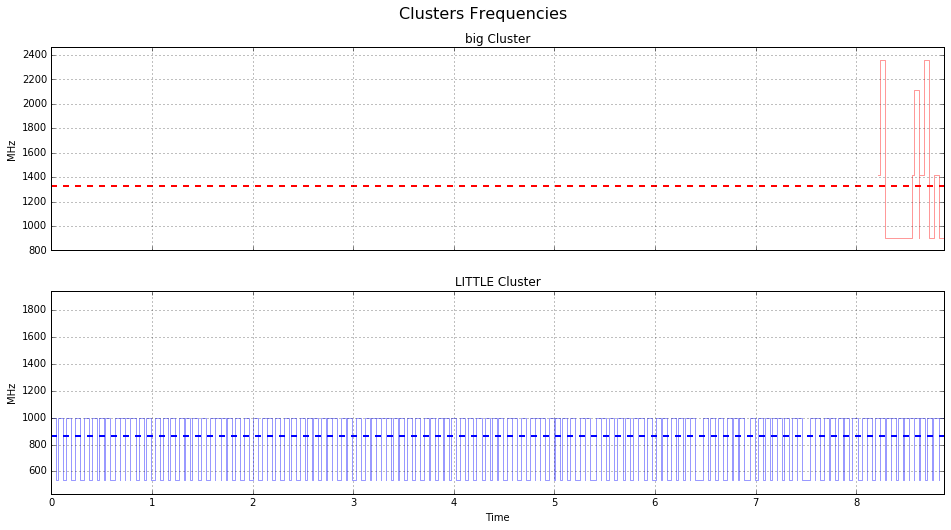

In [20]:
try:
    trace.analysis.frequency.plotClusterFrequencies();
    logging.info('Plotting cluster frequencies for [sched]...')
except: pass